In [1]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import keras
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
# latency_dataset = "../latency_datasets/Dataset_3"
latency_dataset = ""

In [3]:
df_in = pd.read_csv(f"{latency_dataset}table.csv")
df_in.head()

,model,params [K],jevois_latency [ms],sipeed_latency [ms],kmodel_memory [KB],cpu_latency [ms],token_sequence,model_info
0,model_0001,18.780,3.0,46.25,110.59,121.81,"[295, 23, 53, 126, 369, 382]","{""0"": [""DepthwiseConv2D"", 32, [1, 1], [2, 2], ..."
1,model_0002,8.510,6.0,82.36,294.91,85.68,"[31, 236, 319, 336, 374, 382]","{""0"": [""Conv2D"", 8, [3, 3], [2, 2], ""same"", ""s..."
2,model_0003,7.952,6.0,40.45,110.59,83.44,"[185, 43, 28, 94, 267, 382]","{""0"": [""DepthwiseConv2D"", 8, [1, 1], [2, 2], ""..."
3,model_0004,7.288,29.0,369.64,1107.07,90.41,"[241, 25, 360, 142, 26, 382]","{""0"": [""DepthwiseConv2D"", 16, [3, 3], [1, 1], ..."
4,model_0005,59.696,5.0,120.83,246.02,83.69,"[331, 2, 313, 381, 338, 382]","{""0"": [""DepthwiseConv2D"", 40, [1, 1], [2, 2], ..."


In [4]:
df = df_in
df["token_sequence"] = df["token_sequence"].apply(lambda x: json.loads(x))
df_tokens = pd.DataFrame.from_dict(dict(zip(df["token_sequence"].index, df["token_sequence"].values))).T
df_tokens.columns = [f"layer_{i}" for i in range(1, len(df_tokens.columns)+1)]
df = pd.concat([df, df_tokens], axis=1)
df = df.drop(["token_sequence", "model_info"], axis=1)

df = df.dropna()
# df = df.drop(["model", "kmodel_memory [KB]", "cpu_latency [ms]"], axis=1)
df = df.drop(["params [K]", "model", "kmodel_memory [KB]", "jevois_latency [ms]",  "cpu_latency [ms]", "layer_6"], axis=1)
print(len(df))
df.head()

977


,sipeed_latency [ms],layer_1,layer_2,layer_3,layer_4,layer_5
0,46.25,295,23,53,126,369
1,82.36,31,236,319,336,374
2,40.45,185,43,28,94,267
3,369.64,241,25,360,142,26
4,120.83,331,2,313,381,338


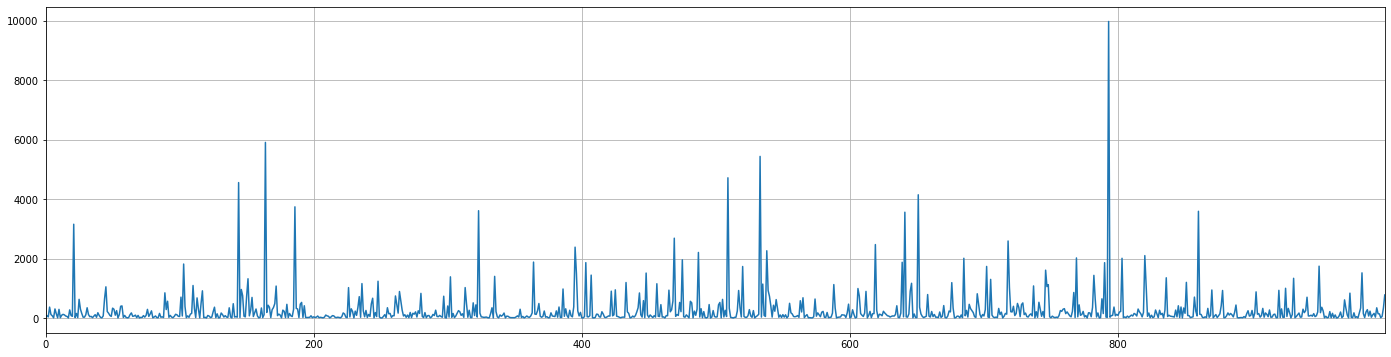

In [5]:
df["sipeed_latency [ms]"].plot(figsize=(24, 6))
plt.grid()
plt.show()

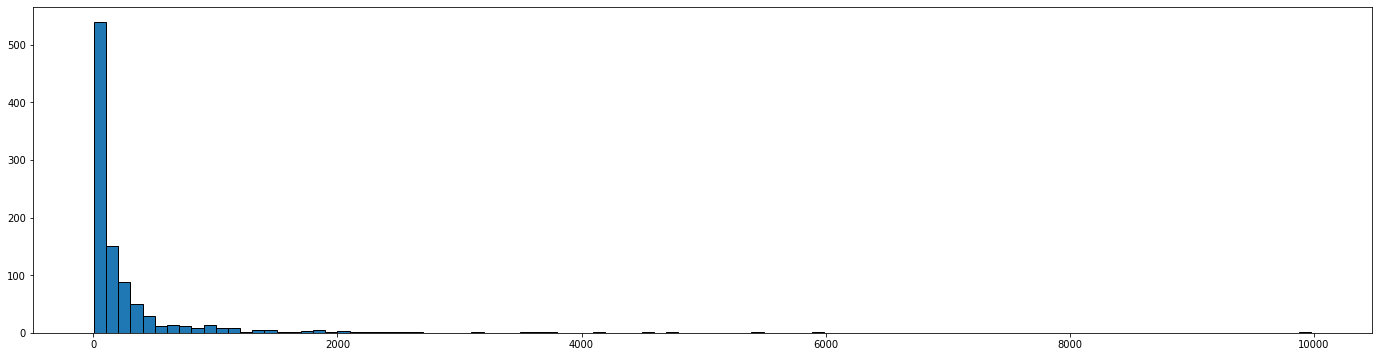

In [6]:
df["sipeed_latency [ms]"].hist(bins=100, edgecolor="k", figsize=(24, 6))
plt.grid()
plt.show()

In [7]:
# remove outliers
df = df[df["sipeed_latency [ms]"] <= 2000]
print(len(df))

956


In [8]:
x = df.loc[:, df.columns != "sipeed_latency [ms]"]
y = df.loc[:, df.columns == "sipeed_latency [ms]"]

In [9]:
# enc = OneHotEncoder(handle_unknown='ignore')
# x_hot = enc.fit_transform(x).toarray()

In [10]:
x_hot = keras.utils.to_categorical(x, num_classes=383)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_hot, y, test_size=0.1, random_state=42)

print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

x_train: (860, 5, 383)
x_test: (96, 5, 383)
y_train: (860, 1)
y_test: (96, 1)


In [12]:
model = None
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, input_shape=(5, 383), activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5, 64)             24576     
_________________________________________________________________
dense_1 (Dense)              (None, 5, 64)             4160      
_________________________________________________________________
dense_2 (Dense)              (None, 5, 32)             2080      
_________________________________________________________________
dense_3 (Dense)              (None, 5, 32)             1056      
_________________________________________________________________
dense_4 (Dense)              (None, 5, 32)             1056      
_________________________________________________________________
dense_5 (Dense)              (None, 5, 16)             528       
_________________________________________________________________
dense_6 (Dense)              (None, 5, 16)             2

In [13]:
history = model.fit(x_train, y_train, epochs=200, validation_split=0.1, verbose=3)

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

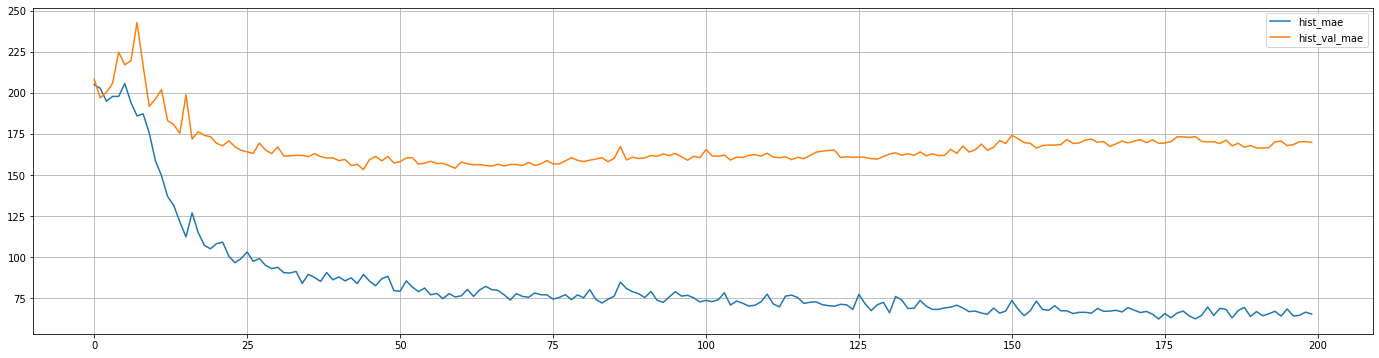

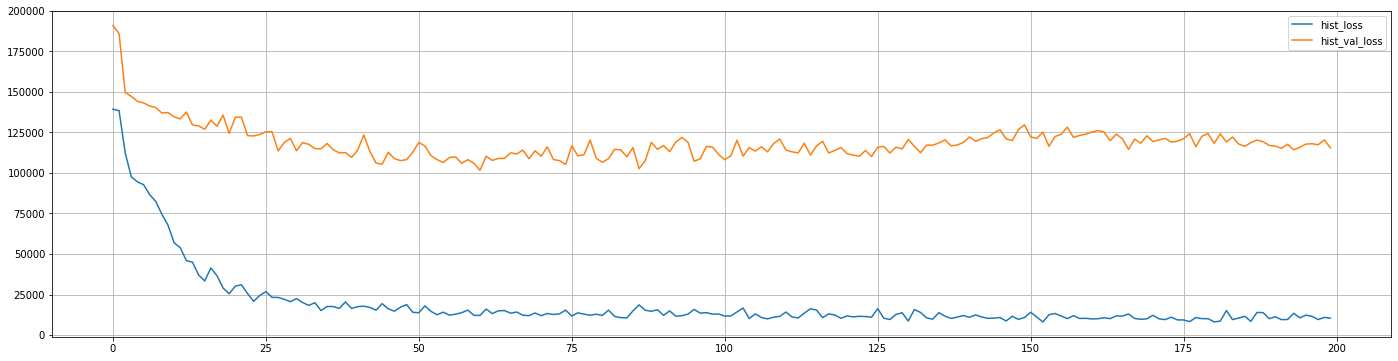

In [14]:
hist_loss = history.history["loss"]
hist_mae = history.history["mae"]
hist_val_loss = history.history["val_loss"]
hist_val_mae = history.history["val_mae"]

fig = plt.figure(figsize=(24, 6))
plt.plot(np.arange(len(hist_mae)), hist_mae, label="hist_mae")
plt.plot(np.arange(len(hist_val_mae)), hist_val_mae, label="hist_val_mae")
plt.grid()
plt.legend()
plt.show()

fig = plt.figure(figsize=(24, 6))
plt.plot(np.arange(len(hist_loss)), hist_loss, label="hist_loss")
plt.plot(np.arange(len(hist_val_loss)), hist_val_loss, label="hist_val_loss")
plt.grid()
plt.legend()
plt.show()

In [15]:
mse_nn, mae_nn = model.evaluate(x_test, y_test)
print("mse: ", mse_nn)
print("mae: ", mae_nn)

3/3 [==============================] - 1s 7ms/step - loss: 38611.6836 - mae: 125.6550
mse:  38611.68359375
mae:  125.65502166748047


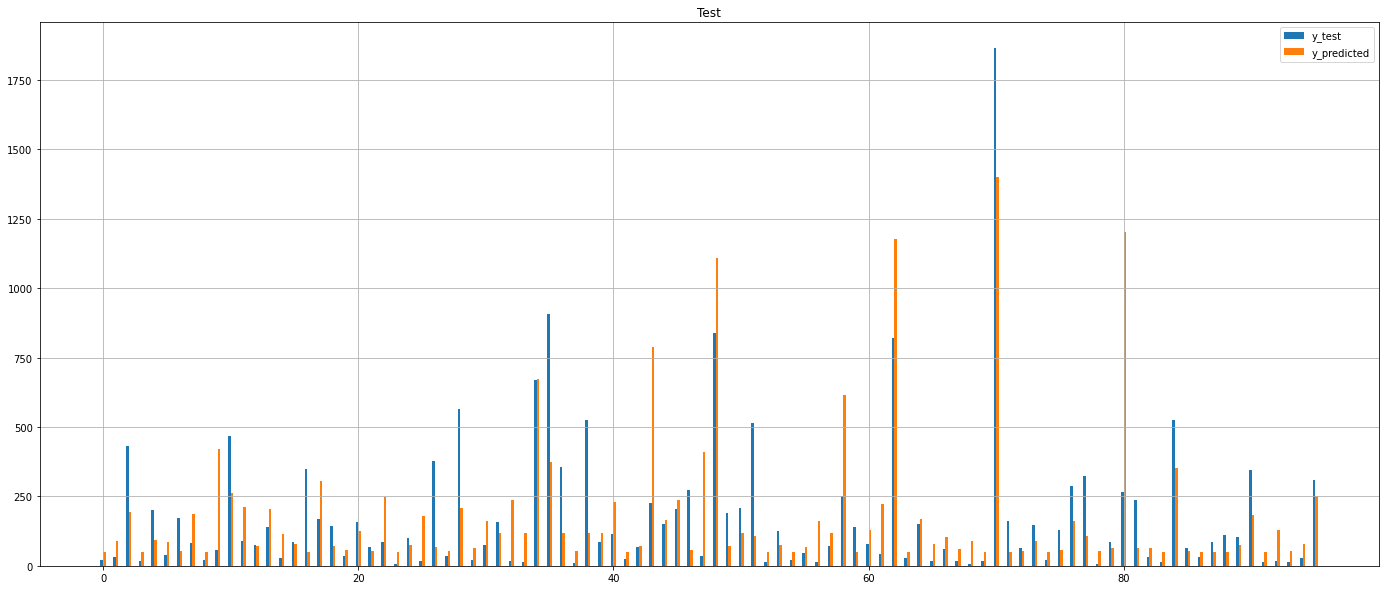

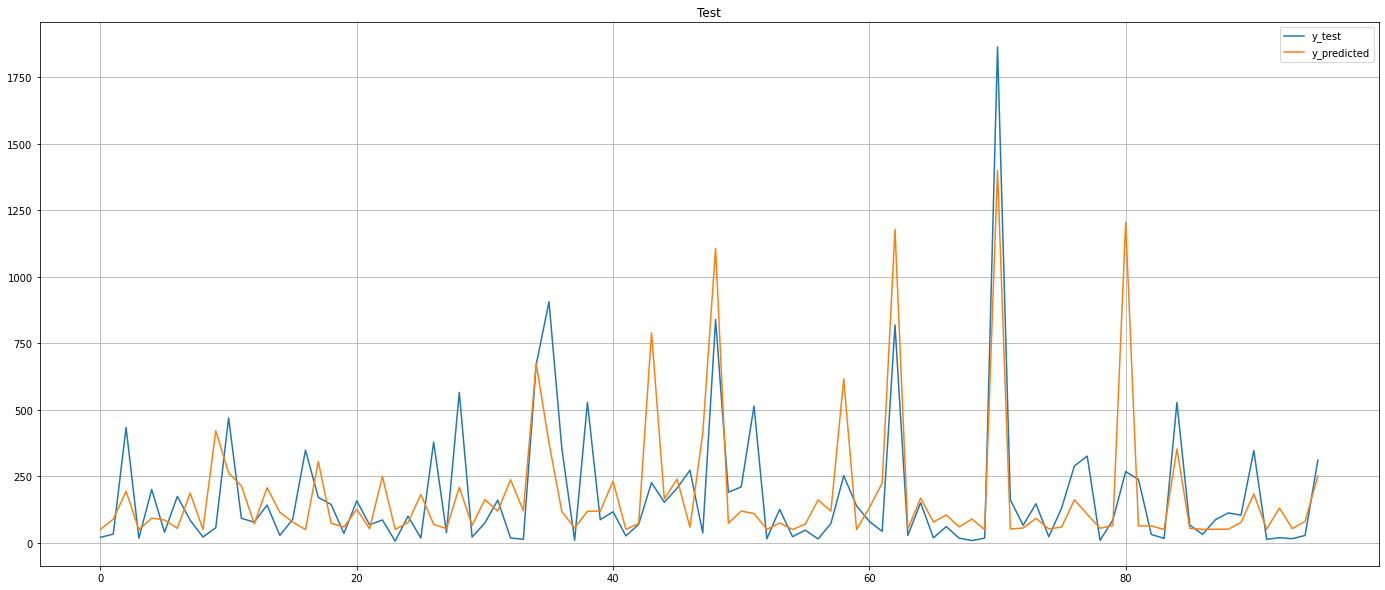

In [16]:
y_predicted = model.predict(x_test)

width = 0.2
fig = plt.figure(figsize=(24, 10))
plt.bar(np.arange(len(y_test)) - width/2, y_test["sipeed_latency [ms]"].to_list(), width, label="y_test")
plt.bar(np.arange(len(y_test)) + width/2, y_predicted.flatten(), width, label="y_predicted")
plt.title("Test")
plt.grid()
plt.legend()
plt.show()

fig = plt.figure(figsize=(24, 10))
plt.plot(np.arange(len(y_test)), y_test, label="y_test")
plt.plot(np.arange(len(y_predicted)), y_predicted, label="y_predicted")
plt.title("Test")
plt.grid()
plt.legend()
plt.show()

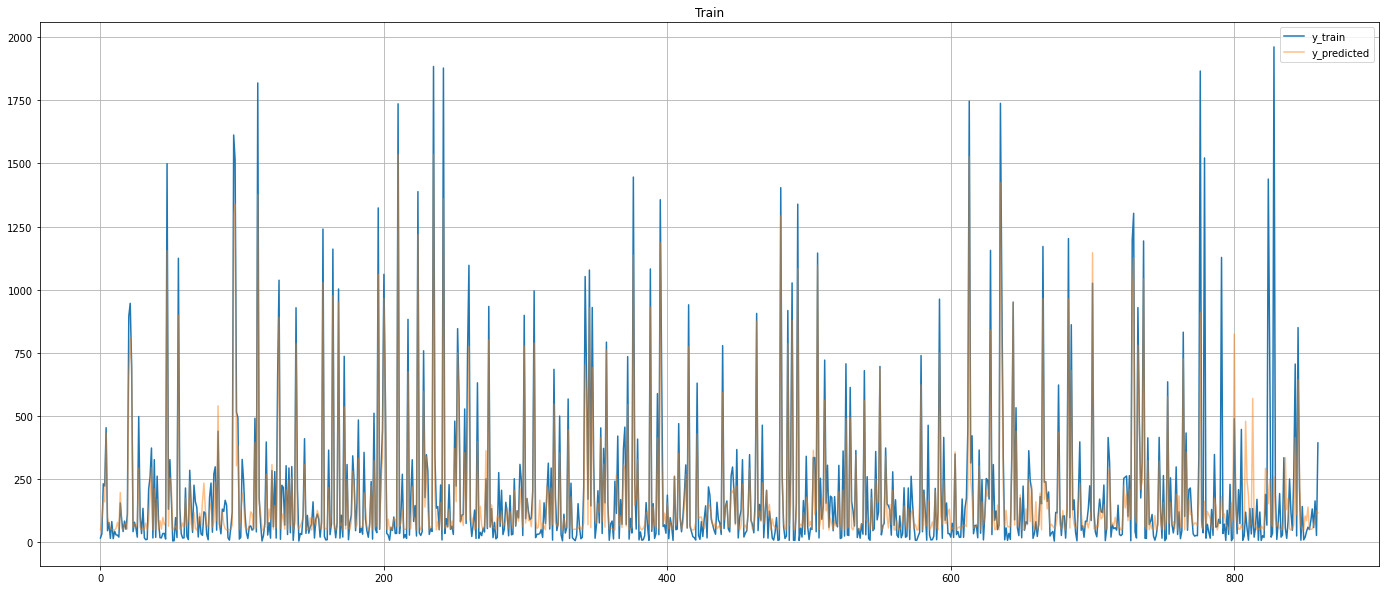

In [17]:
y_predicted_train = model.predict(x_train)

fig = plt.figure(figsize=(24, 10))
plt.plot(np.arange(len(y_train)), y_train, label="y_train")
plt.plot(np.arange(len(y_predicted_train)), y_predicted_train, label="y_predicted", alpha=0.5)
plt.title("Train")
plt.grid()
plt.legend()
# plt.xlim(100,120)
plt.show()